In [1]:
import pandas as pd
import plotnine as p9

In [2]:
def rename_my_cols(col):
    if 'day' in str(col).lower():
        return 'day'
    elif 'hr' in str(col).lower():
        return 'hr'
    else:
        return str(col)

def process_cool_data(startrow, endrow, dose_mgkg):
    skiprows = startrow-1
    nrows = endrow - startrow + 1
    return (
        pd.read_excel('./data/PK_data_scrubbed.xlsx', sheet_name='Serum Data Summary', usecols="A:E", skiprows=skiprows, nrows=nrows)
        .fillna(method='ffill', axis=0)
        .rename(columns=rename_my_cols)
        .assign(
            day=lambda df: [float(x) for x in df.day.str.removeprefix("Day ")],
            hr=lambda df: [float(x) for x in df.hr.str.removesuffix(" hr")],
            t=lambda df: (df.day-1)*24*60*60 + df.hr*60*60
        ).drop(columns=['day', 'hr'])
        .melt(id_vars=['t'], value_name='measurement', var_name='animal_id')
        .assign(
            output='pk_ugml',
            exponential_error='my_exponential_error',
            dose_mgkg=dose_mgkg
        )
    )

Tdat = pd.concat([
    process_cool_data(dose_mgkg=30., startrow=17, endrow=34),
    process_cool_data(dose_mgkg=100., startrow=49, endrow=66),
])

Tdat

/tmp/ipykernel_173208/3307943713.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
/tmp/ipykernel_173208/3307943713.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


,t,animal_id,measurement,output,exponential_error,dose_mgkg
0,1800.0,1001,1488.017589,pk_ugml,my_exponential_error,30.0
1,21600.0,1001,1212.752505,pk_ugml,my_exponential_error,30.0
2,43200.0,1001,397.005151,pk_ugml,my_exponential_error,30.0
3,86400.0,1001,237.193073,pk_ugml,my_exponential_error,30.0
4,259200.0,1001,229.971061,pk_ugml,my_exponential_error,30.0
...,...,...,...,...,...,...
46,950400.0,2003,1028.523938,pk_ugml,my_exponential_error,100.0
47,1209600.0,2003,1292.207918,pk_ugml,my_exponential_error,100.0
48,1211400.0,2003,1825.942229,pk_ugml,my_exponential_error,100.0
49,1296000.0,2003,963.914828,pk_ugml,my_exponential_error,100.0


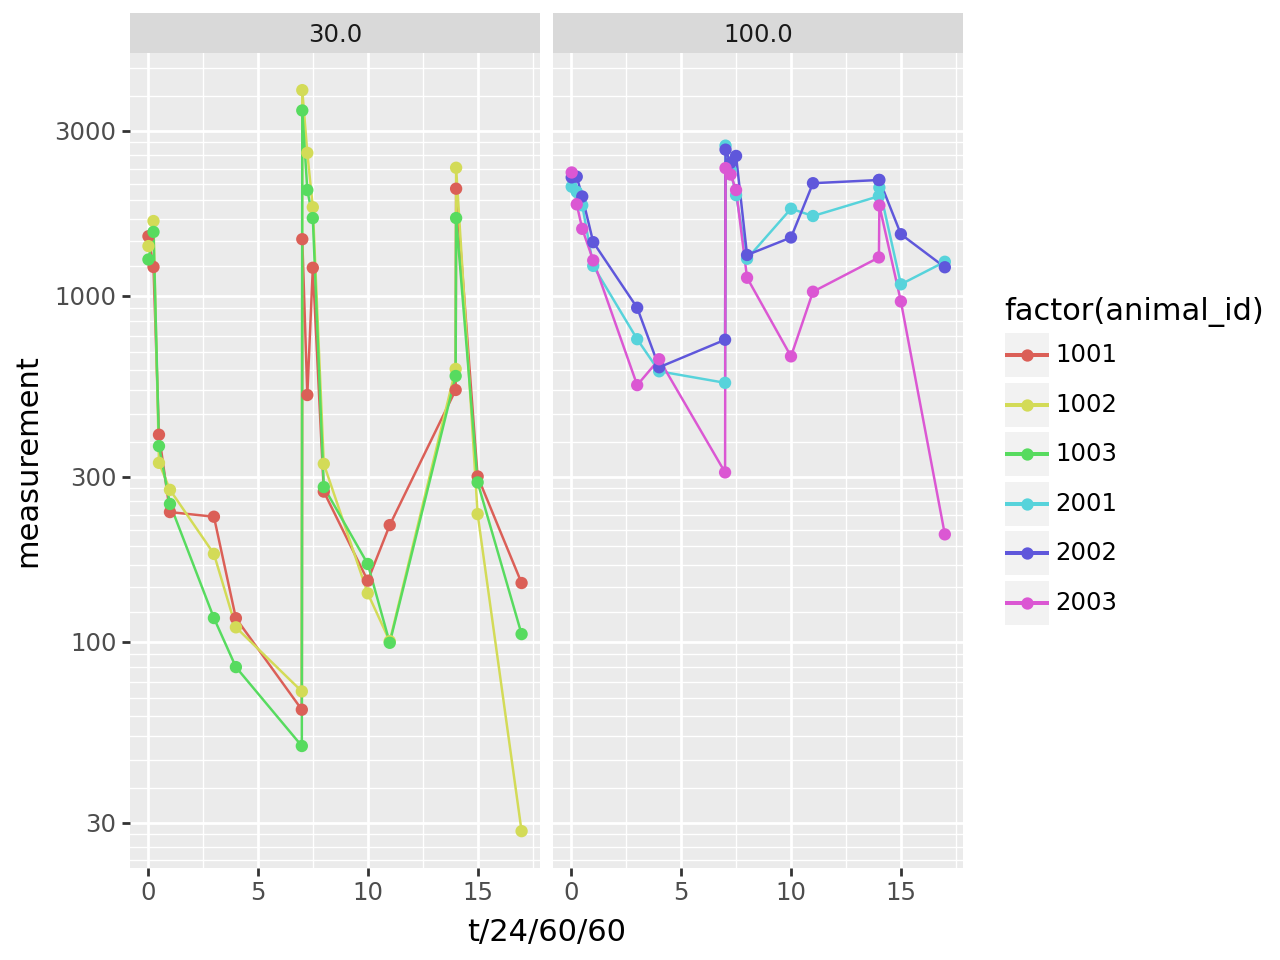

In [3]:
(
    p9.ggplot(Tdat, p9.aes('t/24/60/60', 'measurement', color='factor(animal_id)'))
    + p9.geom_line()
    + p9.geom_point() 
    + p9.scale_y_log10()
    + p9.facet_wrap('~ dose_mgkg')
)